# Assignment

In [1]:
# Import 

import numpy as np
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *


size_board = 4

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [46]:
## INITIALISE THE ENVIRONMENT

env=Chess_Env(size_board)

In [3]:
## PRINT 5 STEPS OF AN EPISODE CONSIDERING A RANDOM AGENT

S,X,allowed_a=env.Initialise_game()                       # INTIALISE GAME

print(S)                                                  # PRINT CHESS BOARD (SEE THE DESCRIPTION ABOVE)

print('check? ',env.check)                                # PRINT VARIABLE THAT TELLS IF ENEMY KING IS IN CHECK (1) OR NOT (0)
print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))    # PRINT THE NUMBER OF LOCATIONS THAT THE ENEMY KING CAN MOVE TO


for i in range(5):
    
    a,_=np.where(allowed_a==1)                  # FIND WHAT THE ALLOWED ACTIONS ARE
    a_agent=np.random.permutation(a)[0]         # MAKE A RANDOM ACTION

    S,X,allowed_a,R,Done=env.OneStep(a_agent)   # UPDATE THE ENVIRONMENT

    ## PRINT CHESS BOARD AND VARIABLES
    print('')
    print(S)
    print(R,'', Done)
    print('check? ',env.check)
    print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))
    
    
    # TERMINATE THE EPISODE IF Done=True (DRAW OR CHECKMATE)
    if Done:
        break
        


[[3 0 0 0]
 [0 0 0 0]
 [0 0 0 1]
 [0 0 2 0]]
check?  0
dofk2  2

[[3 0 0 0]
 [0 0 1 0]
 [0 0 0 0]
 [0 0 2 0]]
0.0  1
check?  0
dofk2  0


In [4]:
# PERFORM N_episodes=1000 EPISODES MAKING RANDOM ACTIONS AND COMPUTE THE AVERAGE REWARD AND NUMBER OF MOVES 

S,X,allowed_a=env.Initialise_game()
N_episodes=1000

# VARIABLES WHERE TO SAVE THE FINAL REWARD IN AN EPISODE AND THE NUMBER OF MOVES 
R_save_random = np.zeros([N_episodes, 1])
N_moves_save_random = np.zeros([N_episodes, 1])

for n in range(N_episodes):
    
    S,X,allowed_a=env.Initialise_game()     # INITIALISE GAME
    Done=0                                  # SET Done=0 AT THE BEGINNING
    i=1                                     # COUNTER FOR THE NUMBER OF ACTIONS (MOVES) IN AN EPISODE
    
    # UNTIL THE EPISODE IS NOT OVER...(Done=0)
    while Done==0:
        
        # SAME AS THE CELL BEFORE, BUT SAVING THE RESULTS WHEN THE EPISODE TERMINATES 
        
        a_base,_=np.where(allowed_a==1)
        
        a_agent_base=np.random.permutation(a_base)[0]

        S,X,allowed_a,R,Done=env.OneStep(a_agent_base)
                
        if Done:
            
            R_save_random[n]=np.copy(R)
            N_moves_save_random[n]=np.copy(i)

            break

        i=i+1                               # UPDATE THE COUNTER



# AS YOU SEE, THE PERFORMANCE OF A RANDOM AGENT ARE NOT GREAT, SINCE THE MAJORITY OF THE POSITIONS END WITH A DRAW 
# (THE ENEMY KING IS NOT IN CHECK AND CAN'T MOVE)

print('Random_Agent, Average reward:',np.mean(R_save_random),'Number of steps: ',np.mean(N_moves_save_random))



Random_Agent, Average reward: 0.2 Number of steps:  6.951


In [53]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...
# PLEASE CONSIDER TO USE A MASK OF ONE FOR THE ACTION MADE AND ZERO OTHERWISE IF YOU ARE NOT USING VANILLA GRADIENT DESCENT...
# WE SUGGEST A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200. 

import tensorflow as tf
from tensorflow import keras

S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES


## INITALISE YOUR NEURAL NETWORK...
init = tf.keras.initializers.HeUniform()
model = keras.Sequential()
model.add(keras.layers.Dense(24, input_shape=(np.shape(X)), activation='relu', kernel_initializer=init))
model.add(keras.layers.Dense(N_h, activation='relu', kernel_initializer=init))
model.add(keras.layers.Dense(32, activation='linear', kernel_initializer=init))
model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])
target_model = model

# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

N_episodes = 5000 # THE NUMBER OF GAMES TO BE PLAYED 
max_T = 200 # maximum number of actions per episode
# SAVING VARIABLES
R_save = np.zeros([N_episodes, max_T ])
N_moves_save = np.zeros([N_episodes])


Qtable = np.random.randn(1, N_a)/1000

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
def EpsilonGreedy_Policy(Qvalues, epsilon, allowed_a):
    allowed_ind,_=np.where(allowed_a==1)
    Qvalues_allowed = np.take(Qvalues, allowed_ind)
    
    rand_value=np.random.uniform(0,1)
    rand_a=rand_value<epsilon

    if rand_a==True:
        a = np.random.choice(allowed_ind)
    else:
        a_q = np.argmax(Qvalues_allowed)
        a = allowed_ind[a_q] 
    return a

In [ ]:
# SARSA

eligibility_trace = True
if eligibility_trace:
    lamb=0.3
    eta=0.08


for n in range(N_episodes):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
 
    # add state X to all states
    X_all = np.array([X])
    ind_x = -1
    count = -1
    for el in X_all:
        count += 1
        if np.array_equal(el, X):
            ind_x = count 

    if ind_x == -1:
        np.append(X_all, [X], axis=0)
        Q = np.random.randn(1, N_a)/1000
        np.append(Qtable, Q, axis=0)

    Qvalues = np.copy(Qtable[ind_x, :])
    
    # chose a from Q values with epsilon greedy
    a = EpsilonGreedy_Policy(Qvalues, epsilon_0, allowed_a) #make an action

    while Done==0:                           ## START THE EPISODE
        # take action a
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a)
        R_save[n, i-1] = np.copy(R)
        N_moves_save[n] = np.copy(i)
        
        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1 or i >= max_T:
                   
            break
           
        
        
        # IF THE EPISODE IS NOT OVER...
        else:
            
            ## ONLY TO PUT SUMETHING
            PIPPO=1
        
        #check if state X is in the Q table by finding index of X_all and select state as Q values
        # otherwise append row (X) to the Q table with random values and append X to X_all
        ind_x_next = -1
        count = -1
        for el in X_all:
            count += 1
            if np.array_equal(el, X_next):
                ind_x_next = count 
                
        if ind_x_next == -1:
            np.append(X_all, [X_next], axis=0)
            Q = np.random.randn(1, N_a)/1000
            np.append(Qtable, Q, axis=0)
            
        Qvalues = np.copy(Qtable[ind_x_next, :])

        # chose a next from Q values with epsilon greedy
        a_next = EpsilonGreedy_Policy(Qvalues, epsilon_f, allowed_a_next) #make an action
        
        # Compute the delta
        delta=R+gamma*Qtable[ind_x_next, a_next]-Qtable[ind_x, a]
        
        # Update the Qvalues
        Qtable[ind_x, a]=Qtable[ind_x, a]+eta*delta

        # NEXT STATE AND CO. BECOME ACTUAL STATE...    
        a=np.copy(a_next)
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        ind_x = np.copy(ind_x_next)
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS

    

In [23]:
def EpsilonGreedy_Policy(state, epsilon, allowed_a):
    allowed_ind,_=np.where(allowed_a==1)
    Qvalues_allowed = np.take(Qvalues, allowed_ind)
    
    rand_value=np.random.uniform(0,1)
    rand_a=rand_value<epsilon

    if rand_a==True:
        a = np.random.choice(allowed_ind)
    else:
        encoded = state
        encoded_reshaped = encoded.reshape([1, encoded.shape[0]])
        predicted = model.predict(encoded_reshaped).flatten()
        predicted_allowed = np.take(predicted, allowed_ind)
        a_p = np.argmax(predicted_allowed)
        a = allowed_ind[a_p] 
          
    return a

In [44]:
def train(env, replay_memory, model, target_model, done):
    learning_rate = 0.7 # Learning rate
    discount_factor = 0.618

    # MIN_REPLAY_SIZE = 100
    # if len(replay_memory) < MIN_REPLAY_SIZE:
    #    return

    batch_size = 64 * 2
    # mini_batch = random.sample(replay_memory, batch_size)
    current_states = np.array([transition[0] for transition in replay_memory])
    current_qs_list = model.predict(current_states)
    new_current_states = np.array([transition[3] for transition in replay_memory])
    future_qs_list = target_model.predict(new_current_states)

    X = []
    Y = []
    for index, (observation, action, reward, new_observation, done) in enumerate(replay_memory):
        if not done:
            max_future_q = reward + discount_factor * np.max(future_qs_list[index])
        else:
            max_future_q = reward

        current_qs = current_qs_list[index]
        current_qs[action] = (1 - learning_rate) * current_qs[action] + learning_rate * max_future_q

        X.append(observation)
        Y.append(current_qs)
    model.fit(np.array(X), np.array(Y), batch_size=batch_size, verbose=0, shuffle=True)


In [54]:
# Deep RL
from collections import deque
import time
import random

replay_memory = deque(maxlen=50_000)
target_update_counter = 0

# X = states, y = actions
X = []
y = []

steps_to_update_target_model = 0

for n in range(N_episodes):
    total_training_rewards = 0

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
    
    # chose a from Q values with epsilon greedy
    a = EpsilonGreedy_Policy(X, epsilon_0, allowed_a) #make an action

    while Done==0:                           ## START THE EPISODE
        steps_to_update_target_model += 1

        # take action a
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a)
        R_save[n, i-1] = np.copy(R)
        N_moves_save[n] = np.copy(i)

        replay_memory.append([X, a, R, X_next, Done])

        
        # train(env, replay_memory, model, target_model, Done)

        total_training_rewards += R
        
        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1 or i >= max_T:
            print('Total training rewards: {} after n steps = {} with final reward = {}'.format(total_training_rewards, n, R))
            total_training_rewards += 1

            if steps_to_update_target_model >= 100:
                print('Copying main network weights to the target network weights')
                target_model.set_weights(model.get_weights())
                steps_to_update_target_model = 0
            break 
        
        
        # IF THE EPISODE IS NOT OVER...
        else:
            
            ## ONLY TO PUT SUMETHING
            PIPPO=1
        

        # chose a next from Q values with epsilon greedy
        a_next = EpsilonGreedy_Policy(X, epsilon_f, allowed_a_next) #make an action
        
        # NEXT STATE AND CO. BECOME ACTUAL STATE...    
        a=np.copy(a_next)
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS

    

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Copying main network weights to the target network weights
Total training rewards: 0.0 after n steps = 384 with final reward = 0.0
Total training rewards: 0.0 after n steps = 385 with final reward = 0.0
Total training rewards: 1 after n steps = 386 with final reward = 1
Total training rewards: 0.0 after n steps = 387 with final reward = 0.0
Total training rewards: 0.0 after n steps = 388 with final reward = 0.0
Total training rewards: 1 after n steps = 389 with final reward = 1
Total training rewards: 1 after n steps = 390 with final reward = 1
Total training rewards: 0.0 after n steps = 391 with final reward = 0.0
Total training rewards: 0.0 after n steps = 392 with final reward = 0.0
Total training rewards: 1 after n steps = 393 with final reward = 1
Total training rewards: 0.0 after n steps = 394 with final reward = 0.0
Copying main network weights to the target network weights
Total training rewards: 1 after n steps

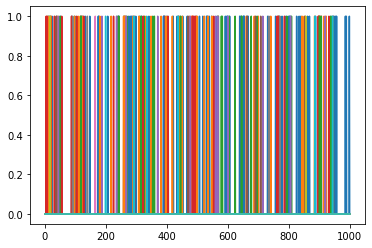

In [52]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,4))
ax.xlim=()
ax.ylim=()

ax.plot(np.linspace(1, N_episodes, num=N_episodes), R_save)


In [55]:
np.average(N_moves_save)

9.1294

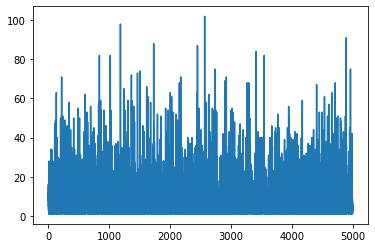

In [56]:
fig, ax = plt.subplots(figsize=(6,4))
ax.xlim=()
ax.ylim=()

ax.plot(np.linspace(1, N_episodes, num=N_episodes), N_moves_save)